In [1]:
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import List, Union
from transformers import AutoTokenizer, AutoModel

class MyDataset(Dataset):
    def __init__(self, 
                ids: List[str], 
                speakers: List[str], 
                sexes: List[str], 
                texts: List[str], 
                texts_en: List[str], 
                labels: List[bool],
                device: torch.device = torch.device('cpu'),
                model_name: str = 'distilbert/distilbert-base-uncased-finetuned-sst-2-english',
                max_length: int = 512
        ):
        assert len(ids) == len(speakers) == len(sexes) == len(texts) == len(texts_en) == len(labels)
        self.ids = []
        self.speakers = []
        self.sexes = []
        self.texts = []
        self.texts_en = []
        self.embeddings = []
        self.attention_masks = []
        self.labels = []
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        for i in range(len(ids)):
            inputs = self.tokenizer(texts[i], add_special_tokens=True, return_tensors='pt', padding='max_length',max_length=max_length)
            if inputs['input_ids'].shape[1] <= max_length:
                inputs = self.tokenizer(texts_en[i], add_special_tokens=True, return_tensors='pt', padding='max_length',max_length=max_length)
                self.ids.append(ids[i])
                self.speakers.append(speakers[i])
                self.sexes.append(sexes[i])
                self.texts.append(texts[i])
                self.texts_en.append(texts_en[i])
                self.embeddings.append(inputs['input_ids'][0])
                self.attention_masks.append(inputs['attention_mask'])
                self.labels.append(torch.tensor((labels[i]), dtype=torch.long))
                
        print(f'Loaded {len(self.ids)}/{len(ids)} samples.')

    def __getitem__(self, index):
        return self.ids[index], self.speakers[index], self.sexes[index], self.texts[index], \
                self.texts_en[index], self.embeddings[index][:512].to(self.device), self.attention_masks[index][0][:512].to(self.device), self.labels[index]
            
    def __len__(self):
        return len(self.ids)

    def set_device(self, device: torch.device):
        '''
        Sets the device to the given device.
        '''
        self.device = device

C:\Users\Barbara\anaconda3\envs\nlp_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import List, Union
from transformers import AutoTokenizer, AutoModel, PreTrainedModel
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate(dataset: Dataset, model: PreTrainedModel, device: torch.device = torch.device('cpu'), batch_size = 1):
    '''
    Evaluates the model on the given dataset.
    
    Parameters:
        dataset: Dataset
            The dataset to evaluate on.
        model: PreTrainedModel
            The model to evaluate.
        device: torch.device
            The device to use.
        plot: bool
    '''
    model.to(device)
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    correct_labels = []
    model_predictions = []
    with torch.no_grad():
        for batch in loader:
            id_, speaker, sex, text, text_en, embedding, attention_mask, label = batch
            embedding = embedding.to(device)
            attention_mask = attention_mask.to(device).squeeze(1)
            label = label.to(device)
            model_output = model(input_ids=embedding, labels=label, attention_mask=attention_mask)
            logits = model_output.logits
            predictions = torch.argmax(logits, dim=1)
            correct_labels.extend(label.cpu().numpy())
            model_predictions.extend(predictions.cpu().numpy())

    accuracy = accuracy_score(correct_labels, model_predictions)
    cls_dict = classification_report(correct_labels, model_predictions, zero_division = 0.0, output_dict=True)
    print(classification_report(correct_labels, model_predictions, zero_division = 0.0))
    print(f'Accuracy: {accuracy}')
    print(f'Confusion matrix:\n{confusion_matrix(correct_labels, model_predictions)}')
    return cls_dict

In [3]:
import types
import sys

dataset_valid = torch.load('D:/fer/9.sem/OPJ/data/torch/orientation/val_dataset_all.pt')
dataset_train = torch.load('D:/fer/9.sem/OPJ/data/torch/orientation/train_dataset_all.pt')
dataset_test = torch.load('D:/fer/9.sem/OPJ/data/torch/orientation/test_dataset_all.pt')

C:\Users\Barbara\AppData\Local\Temp\ipykernel_5440\1513614665.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset_valid = torch.load('D:/fer/9.sem/OPJ/data/torch/ori

In [4]:
left_v = 0
right_v = 0
for example in dataset_valid:
    if example[-1] == 0:
        left_v += 1
    else:
        right_v += 1

print(f'Validation set: {left_v} left, {right_v} right')

Validation set: 1705 left, 2335 right


In [5]:
left_t = 0
right_t = 0
for example in dataset_train:
    if example[-1] == 0:
        left_t += 1
    else:
        right_t += 1
    
print(f'Training set: {left_t} left, {right_t} right')

Training set: 13257 left, 19088 right


In [6]:
left_tt = 0
right_tt = 0
for example in dataset_test:
    if example[-1] == 0:
        left_tt += 1
    else:
        right_tt += 1

print(f'Test set: {left_tt} left, {right_tt} right')

Test set: 1661 left, 2369 right


In [7]:
left_total = left_v+left_t+left_tt
right_total = right_v+right_t+right_tt

In [8]:
print(f'Left: {left_total}, Right: {right_total}')

Left: 16623, Right: 23792


In [9]:
print(f'Left: {left_total/(left_total+right_total)*100:.2f}%, Right: {right_total/(left_total+right_total)*100:.2f}%')

Left: 41.13%, Right: 58.87%


In [10]:
import os
DATASET_DIR = 'D:/fer/9.sem/OPJ/data/torch/orientation'
c_dict = {'train': {}, 'val': {}, 'test': {}}
for filename in os.listdir(DATASET_DIR):
    if filename.endswith(".pt"):
        file_path = os.path.join(DATASET_DIR, filename)
        dataset = torch.load(file_path)
        if 'train' in filename:
            c_dict['train'][filename] = dataset

        elif 'val' in filename:
            c_dict['val'][filename] = dataset

        elif 'test' in filename:
            c_dict['test'][filename] = dataset

C:\Users\Barbara\AppData\Local\Temp\ipykernel_5440\1230278298.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(file_path)


In [11]:
# Identify countries to remove
countries_to_remove = set()

for key in c_dict:
    for filename in c_dict[key]:
        if len(c_dict[key][filename]) == 0:
            # Extract country code from the filename
            if "orientation-" in filename:
                country = filename.split("orientation-")[-1].split(".pt")[0]
                countries_to_remove.add(country)

# Create a new dictionary without the countries to remove
filtered_c_dict = {}

for key in c_dict:
    filtered_c_dict[key] = {}
    for filename in c_dict[key]:
        if "orientation-" in filename:
            country = filename.split("orientation-")[-1].split(".pt")[0]
            if country not in countries_to_remove:
                filtered_c_dict[key][filename] = c_dict[key][filename]
        else:
            # Keep non-country-specific entries
            filtered_c_dict[key][filename] = c_dict[key][filename]

# Output the filtered dictionary
for key in filtered_c_dict:
    print(key)
    for filename in filtered_c_dict[key]:
        print(f'    {filename}: {len(filtered_c_dict[key][filename])}')


train
    train_dataset_all.pt: 32345
    train_dataset_orientation-at.pt: 431
    train_dataset_orientation-ba.pt: 319
    train_dataset_orientation-be.pt: 608
    train_dataset_orientation-cz.pt: 769
    train_dataset_orientation-dk.pt: 672
    train_dataset_orientation-ee.pt: 1212
    train_dataset_orientation-es-ct.pt: 79
    train_dataset_orientation-es-ga.pt: 14
    train_dataset_orientation-es.pt: 96
    train_dataset_orientation-fi.pt: 256
    train_dataset_orientation-fr.pt: 1249
    train_dataset_orientation-gb.pt: 12157
    train_dataset_orientation-hr.pt: 1791
    train_dataset_orientation-hu.pt: 76
    train_dataset_orientation-is.pt: 91
    train_dataset_orientation-it.pt: 525
    train_dataset_orientation-lv.pt: 149
    train_dataset_orientation-nl.pt: 1856
    train_dataset_orientation-no.pt: 2006
    train_dataset_orientation-pl.pt: 1202
    train_dataset_orientation-pt.pt: 513
    train_dataset_orientation-rs.pt: 939
    train_dataset_orientation-se.pt: 973
    train_

In [12]:
from transformers import AutoModel
model = torch.load('D:/fer/9.sem/OPJ/roberta_base_en.pt', map_location=torch.device('cuda:0'))

C:\Users\Barbara\AppData\Local\Temp\ipykernel_5440\305941443.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('D:/fer/9.sem/OPJ/roberta_base_en.pt', ma

In [13]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
performance = {}
for filename in filtered_c_dict['test']:
    dataset_ = filtered_c_dict['test'][filename]
    print(f'{filename}: {len(dataset_)} examples')
    if len(dataset_) != 0:
        report = evaluate(dataset_, model, device=device,batch_size=16)
        performance[filename] = report['weighted avg']['f1-score']

test_dataset_all.pt: 4030 examples
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1661
           1       0.78      0.79      0.79      2369

    accuracy                           0.75      4030
   macro avg       0.74      0.74      0.74      4030
weighted avg       0.75      0.75      0.75      4030

Accuracy: 0.7491315136476426
Confusion matrix:
[[1142  519]
 [ 492 1877]]
test_dataset_orientation-at.pt: 53 examples
              precision    recall  f1-score   support

           0       0.67      0.35      0.46        17
           1       0.75      0.92      0.82        36

    accuracy                           0.74        53
   macro avg       0.71      0.63      0.64        53
weighted avg       0.72      0.74      0.71        53

Accuracy: 0.7358490566037735
Confusion matrix:
[[ 6 11]
 [ 3 33]]
test_dataset_orientation-ba.pt: 39 examples
              precision    recall  f1-score   support

           0       0.33     

C:\Users\Barbara\anaconda3\envs\nlp_env\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.80      0.57      0.67         7

    accuracy                           0.67        12
   macro avg       0.69      0.69      0.67        12
weighted avg       0.70      0.67      0.67        12

Accuracy: 0.6666666666666666
Confusion matrix:
[[4 1]
 [3 4]]
test_dataset_orientation-fi.pt: 32 examples
              precision    recall  f1-score   support

           0       0.67      0.62      0.64        13
           1       0.75      0.79      0.77        19

    accuracy                           0.72        32
   macro avg       0.71      0.70      0.70        32
weighted avg       0.72      0.72      0.72        32

Accuracy: 0.71875
Confusion matrix:
[[ 8  5]
 [ 4 15]]
test_dataset_orientation-fr.pt: 156 examples
              precision    recall  f1-score   support

           0       0.58      0.41      0.48        44
           1       0.79      0.

In [15]:
import re
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Ensure inline plotting for Jupyter notebooks
%matplotlib inline

# Extract country code from file path
def extract_country_code(file_path):
    if 'all' in file_path:
        return 'all_combined'
    if 'train' in file_path:
        match = re.search(r'orientation-([a-z]{2}(?:-[a-z]{2})?).pt', file_path)
        if match:
            return match.group(1)
    
    if 'val' in file_path:
        match = re.search(r'val_dataset_orientation-([a-z]{2}(?:-[a-z]{2})?).pt', file_path)
        if match:
            return match.group(1)
        
    if 'test' in file_path:
        match = re.search(r'orientation-([a-z]{2}(?:-[a-z]{2})?).pt', file_path)
        if match:
            return match.group(1)
        
    print(f"No match found for: {file_path}")
    return None

def get_model_representations(model, dataset_name, dataset, batch_size=1):
    representations = []
    labels = []
    countries = []
    sexes = []
    logits = []
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for ind, batch in enumerate(dataloader):
        id_, speaker, sex, text, text_en, embedding, attention_mask, label = batch
        embedding = embedding.to(device)
        attention_mask = attention_mask.to(device)
        # Get the last hidden state
        outputs = model(input_ids=embedding, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        cls_representation = hidden_states[-1][:,0,:]
        logits_ = outputs.logits
        representations.extend(cls_representation.detach().cpu().numpy())
        labels.extend(label.detach().cpu().numpy())
        countries.extend([extract_country_code(dataset_name) for _ in range(len(label))])
        sexes.extend(sex)
        logits.extend(logits_.detach().cpu().numpy())
            
    sexes = list(map(lambda x: 0 if x == 'F' else 1, sexes))
    return np.array(representations), np.array(labels), np.array(countries), np.array(sexes), np.array(logits)

def extract_representations(dataset_dict):
    representations = np.array([])
    labels = np.array([])
    countries = np.array([])
    sexes = np.array([])
    logits = np.array([])
    for file_path, dataset in dataset_dict.items():
        reps_, labels_, countries_, sexes_, logits_ = get_model_representations(model, file_path, dataset, 16)
        representations = np.concatenate([representations, reps_]) if representations.size else reps_
        labels = np.concatenate([labels, labels_]) if labels.size else labels_
        countries = np.concatenate([countries, countries_]) if countries.size else countries_
        sexes = np.concatenate([sexes, sexes_]) if sexes.size else sexes_
        logits = np.concatenate([logits, logits_]) if logits.size else logits_
        print(f"Processed {file_path}")
        
    return representations, labels, countries, sexes, logits

def calculate_mean_by_country(countries, labels, representations, threshold=1.0):
    mean_representations = {}
    for country in np.unique(countries):
        if representations[(countries == country)].shape[0] < threshold:
            continue
        for label in np.unique(labels):
            reps = representations[(countries == country) & (labels == label)]
            mean_representations[(country, label)] = np.mean(reps, axis=0)
    
    return mean_representations

def calculate_mean_by_country_sex(countries, labels, representations, sexes, threshold=1.0):
    mean_representations = {}
    for country in np.unique(countries):
        if representations[(countries == country)].shape[0] < threshold:
            continue
        for sex in np.unique(sexes):
            for label in np.unique(labels):
                reps = representations[(countries == country) & (sexes == sex) & (labels == label)]
                if reps.size:
                    mean_representations[(country, sex, label)] = np.mean(reps, axis=0)
                else:
                    mean_representations[(country, sex, label)] = np.zeros([768])
                
    return mean_representations

def perform_PCA(vectors):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(vectors)
    return pca_result 
    
def plot_country(pca_result, countries_labels):
    plt.figure(figsize=(25, 14))

    for i, ((country, label), pca_coord) in enumerate(zip(countries_labels, pca_result)):
        color = 'red' if label == 0 else 'blue'
        plt.scatter(pca_coord[0], pca_coord[1], color=color)

    # Connect the points with lines and add country codes
    for country in np.unique([c for c, l in countries_labels]):
        left_coords = pca_result[[i for i, (c, l) in enumerate(countries_labels) if c == country and l == 0]]
        right_coords = pca_result[[i for i, (c, l) in enumerate(countries_labels) if c == country and l == 1]]
        if len(left_coords) > 0 and len(right_coords) > 0:
            plt.plot([left_coords[0][0], right_coords[0][0]], [left_coords[0][1], right_coords[0][1]], 'k-')
            mid_x = (left_coords[0][0] + right_coords[0][0]) / 2
            mid_y = (left_coords[0][1] + right_coords[0][1]) / 2
            plt.text(mid_x, mid_y, country, fontsize=12, color='black', ha='center', va='center')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA of Mean Representations for Left-Wing and Right-Wing Speeches by Country')
    plt.grid(True)
    plt.show()

def plot_country_sex(pca_result, cs_labels):
    plt.figure(figsize=(25, 14))

    for i, ((country, sex, label), pca_coord) in enumerate(zip(cs_labels, pca_result)):
        color = 'red' if label == 0 else 'blue'
        marker = 'v' if sex == 1 else 'o'
        plt.scatter(pca_coord[0], pca_coord[1], color=color, marker=marker)

    # Connect the points with lines and add country codes
    for country in np.unique([c for (c, s, l) in cs_labels]):
        for sex in np.unique([s for (c, s, l) in cs_labels]):
            if (country, sex, 0) not in cs_labels or (country, sex, 1) not in cs_labels:
                continue
            left_coords = pca_result[[i for i, (c, s, l) in enumerate(cs_labels) if c == country and l == 0 and s == sex]]
            right_coords = pca_result[[i for i, (c, s, l) in enumerate(cs_labels) if c == country and l == 1 and s == sex]]
            if len(left_coords) > 0 and len(right_coords) > 0:
                plt.plot([left_coords[0][0], right_coords[0][0]], [left_coords[0][1], right_coords[0][1]], 'k-')
                mid_x = (left_coords[0][0] + right_coords[0][0]) / 2
                mid_y = (left_coords[0][1] + right_coords[0][1]) / 2
                sex_text = "Female" if sex == 0 else "Male"
                text = country + " - " + sex_text
                plt.text(mid_x, mid_y, text, fontsize=12, color='black', ha='center', va='center')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA of Mean Representations for Left-Wing and Right-Wing Speeches by Country')
    plt.grid(True)
    plt.show()

In [16]:
torch.cuda.empty_cache()

In [17]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

In [18]:
# Get BERT representations for the validation data
val_representations, val_labels, val_countries, val_sexes, val_logits = extract_representations(filtered_c_dict['val'])

Processed val_dataset_all.pt
Processed val_dataset_orientation-at.pt
Processed val_dataset_orientation-ba.pt
Processed val_dataset_orientation-be.pt
Processed val_dataset_orientation-cz.pt
Processed val_dataset_orientation-dk.pt
Processed val_dataset_orientation-ee.pt
Processed val_dataset_orientation-es-ct.pt
Processed val_dataset_orientation-es-ga.pt
Processed val_dataset_orientation-es.pt
Processed val_dataset_orientation-fi.pt
Processed val_dataset_orientation-fr.pt
Processed val_dataset_orientation-gb.pt
Processed val_dataset_orientation-hr.pt
Processed val_dataset_orientation-hu.pt
Processed val_dataset_orientation-is.pt
Processed val_dataset_orientation-it.pt
Processed val_dataset_orientation-lv.pt
Processed val_dataset_orientation-nl.pt
Processed val_dataset_orientation-no.pt
Processed val_dataset_orientation-pl.pt
Processed val_dataset_orientation-pt.pt
Processed val_dataset_orientation-rs.pt
Processed val_dataset_orientation-se.pt
Processed val_dataset_orientation-si.pt
Proce

Calculated all representations!


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

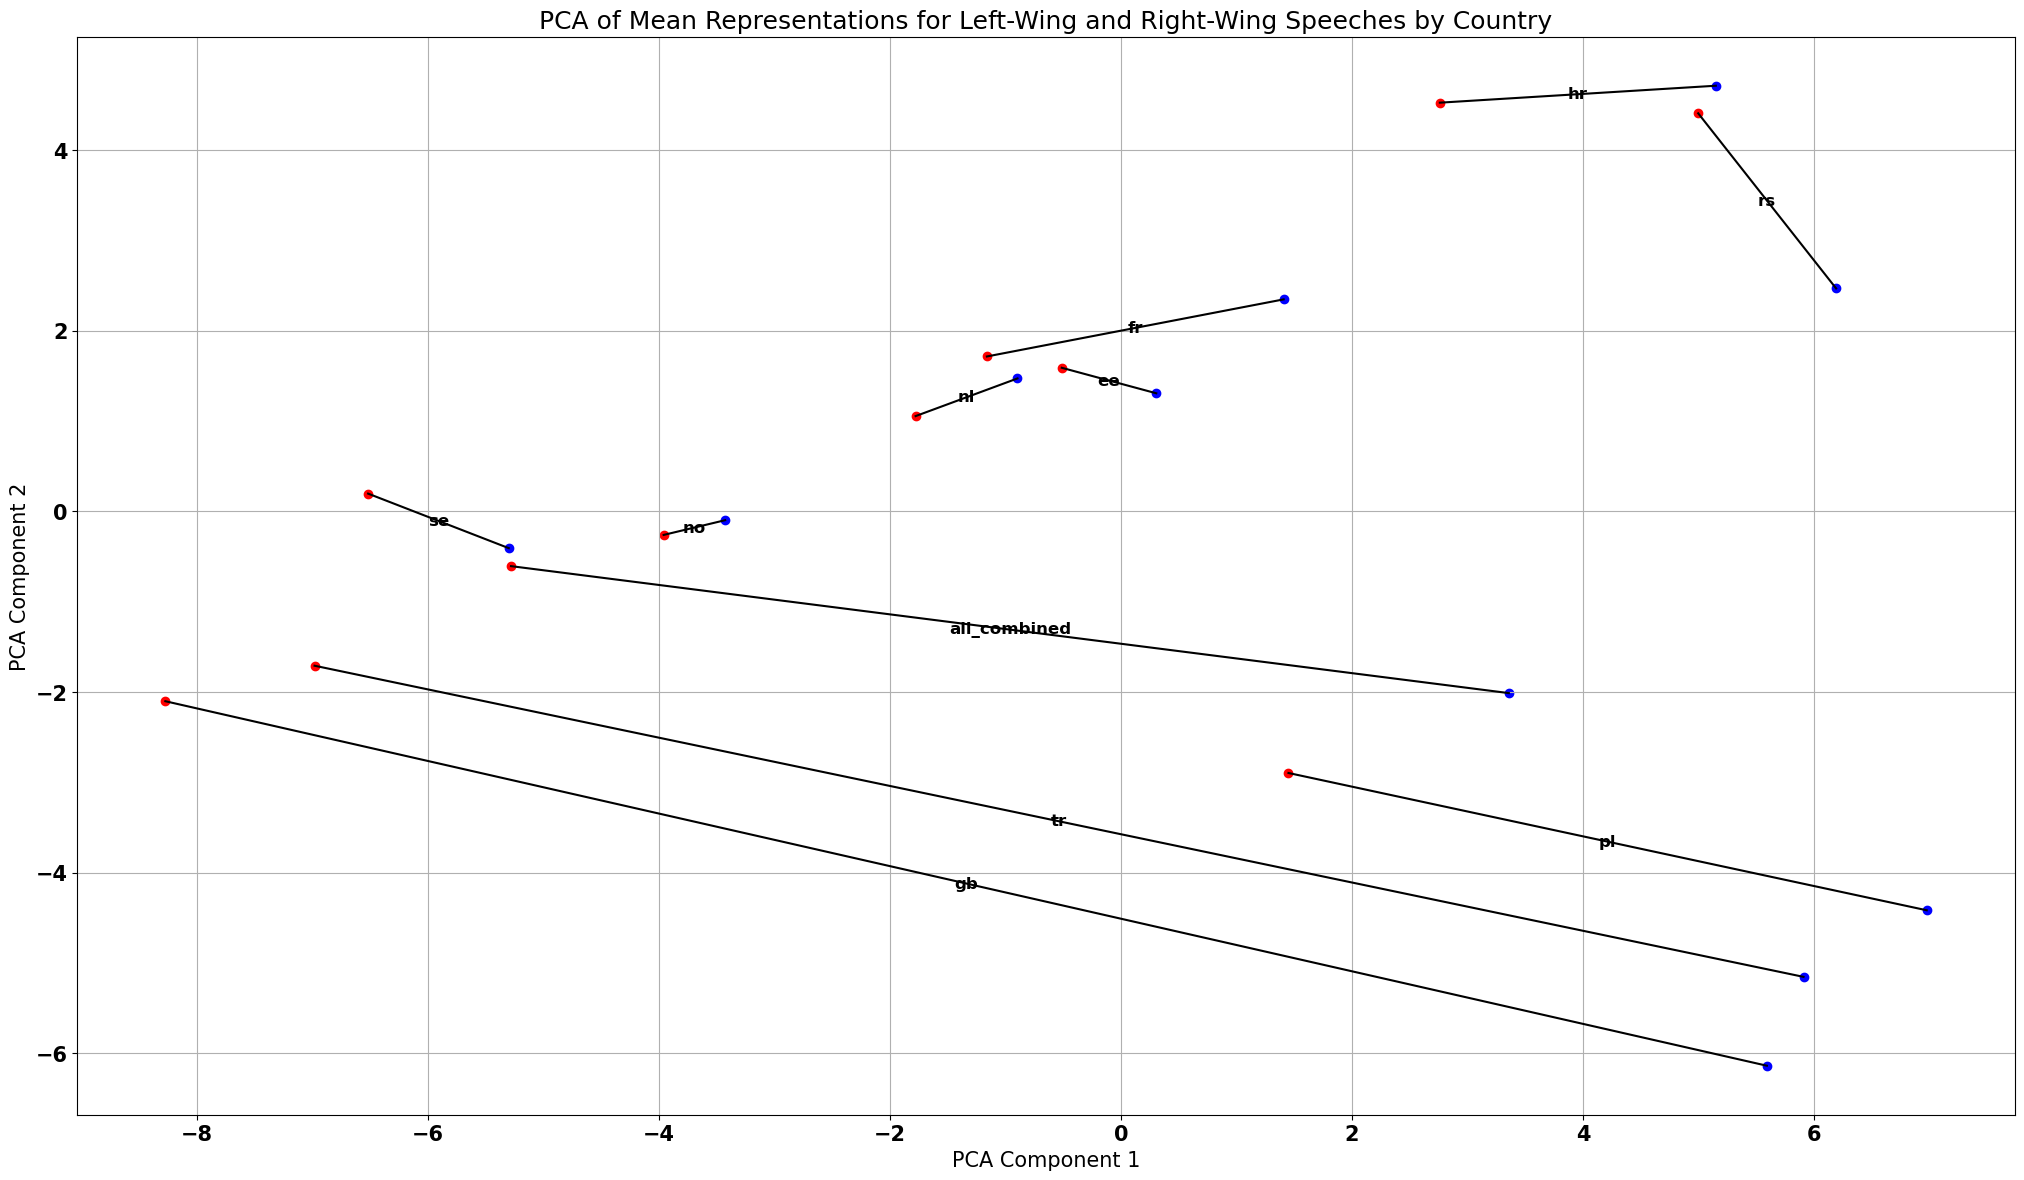

In [19]:
# Calculate mean representations for each country and label
mean_representations_cval = calculate_mean_by_country(val_countries, val_labels, val_representations, threshold=100)
print("Calculated all representations!")

# Prepare data for PCA
mean_reps_cval = np.array(list(mean_representations_cval.values()))
countries_labels_cval = list(mean_representations_cval.keys())

# Perform PCA
pca_result_cval = perform_PCA(mean_reps_cval)

#Plot results
plot_country(pca_result_cval, countries_labels_cval)

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.


Calculated all representations!


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

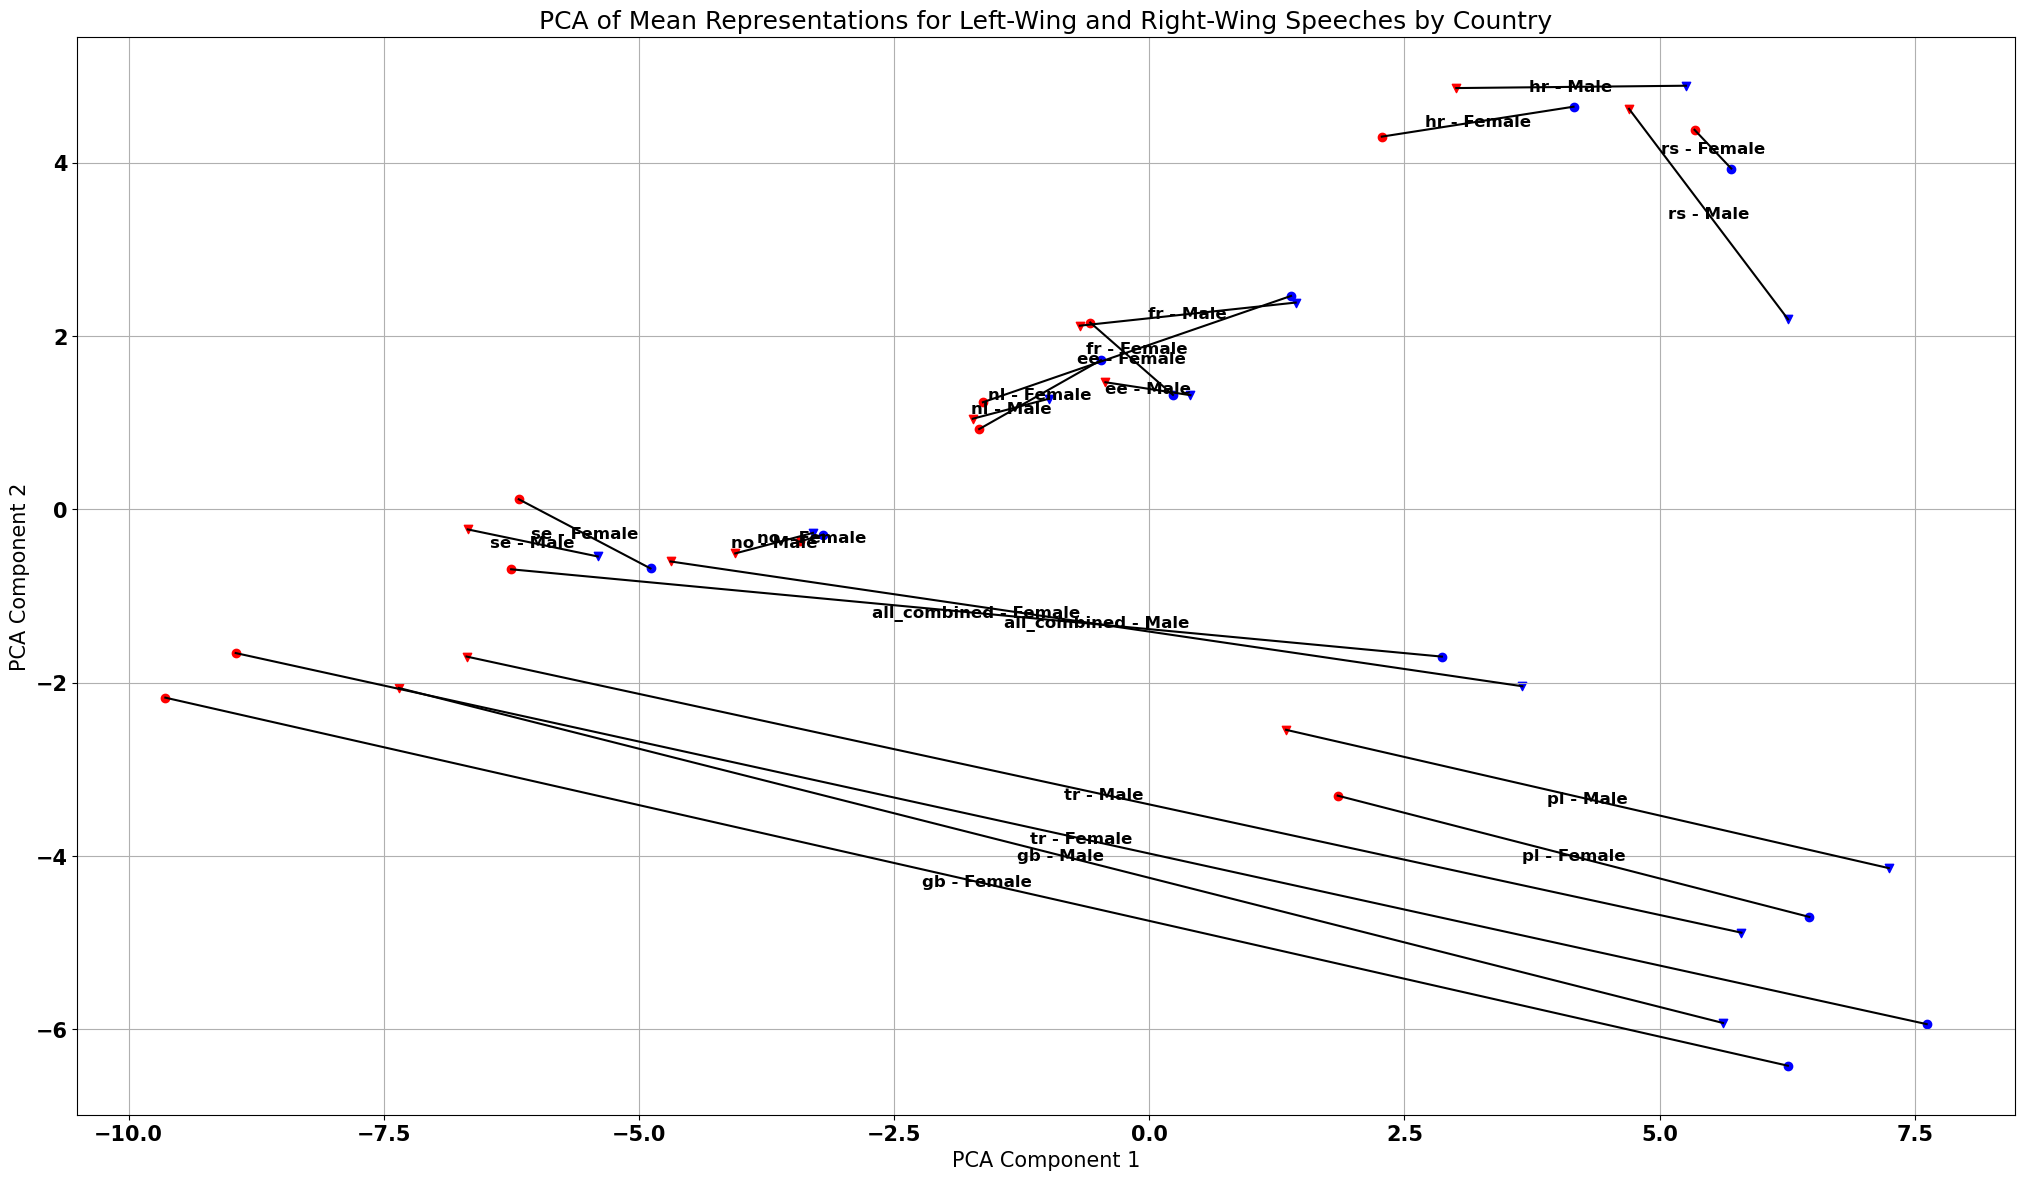

In [20]:
# Calculate mean representations for each country and label
mean_representations_csval = calculate_mean_by_country_sex(val_countries, val_labels, val_representations, val_sexes, threshold=100)
print("Calculated all representations!")

# Prepare data for PCA
mean_reps_csval = np.array(list(mean_representations_csval.values()))
countries_labels_csval = list(mean_representations_csval.keys())

# Perform PCA
pca_result_csval = perform_PCA(mean_reps_csval)

#Plot results
plot_country_sex(pca_result_csval, countries_labels_csval)

In [21]:
# Get BERT representations for the validation data
tr_representations, tr_labels, tr_countries, tr_sexes, tr_logits = extract_representations(filtered_c_dict['train'])

Processed train_dataset_all.pt
Processed train_dataset_orientation-at.pt
Processed train_dataset_orientation-ba.pt
Processed train_dataset_orientation-be.pt
Processed train_dataset_orientation-cz.pt
Processed train_dataset_orientation-dk.pt
Processed train_dataset_orientation-ee.pt
Processed train_dataset_orientation-es-ct.pt
Processed train_dataset_orientation-es-ga.pt
Processed train_dataset_orientation-es.pt
Processed train_dataset_orientation-fi.pt
Processed train_dataset_orientation-fr.pt
Processed train_dataset_orientation-gb.pt
Processed train_dataset_orientation-hr.pt
Processed train_dataset_orientation-hu.pt
Processed train_dataset_orientation-is.pt
Processed train_dataset_orientation-it.pt
Processed train_dataset_orientation-lv.pt
Processed train_dataset_orientation-nl.pt
Processed train_dataset_orientation-no.pt
Processed train_dataset_orientation-pl.pt
Processed train_dataset_orientation-pt.pt
Processed train_dataset_orientation-rs.pt
Processed train_dataset_orientation-se.

Calculated all representations!


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

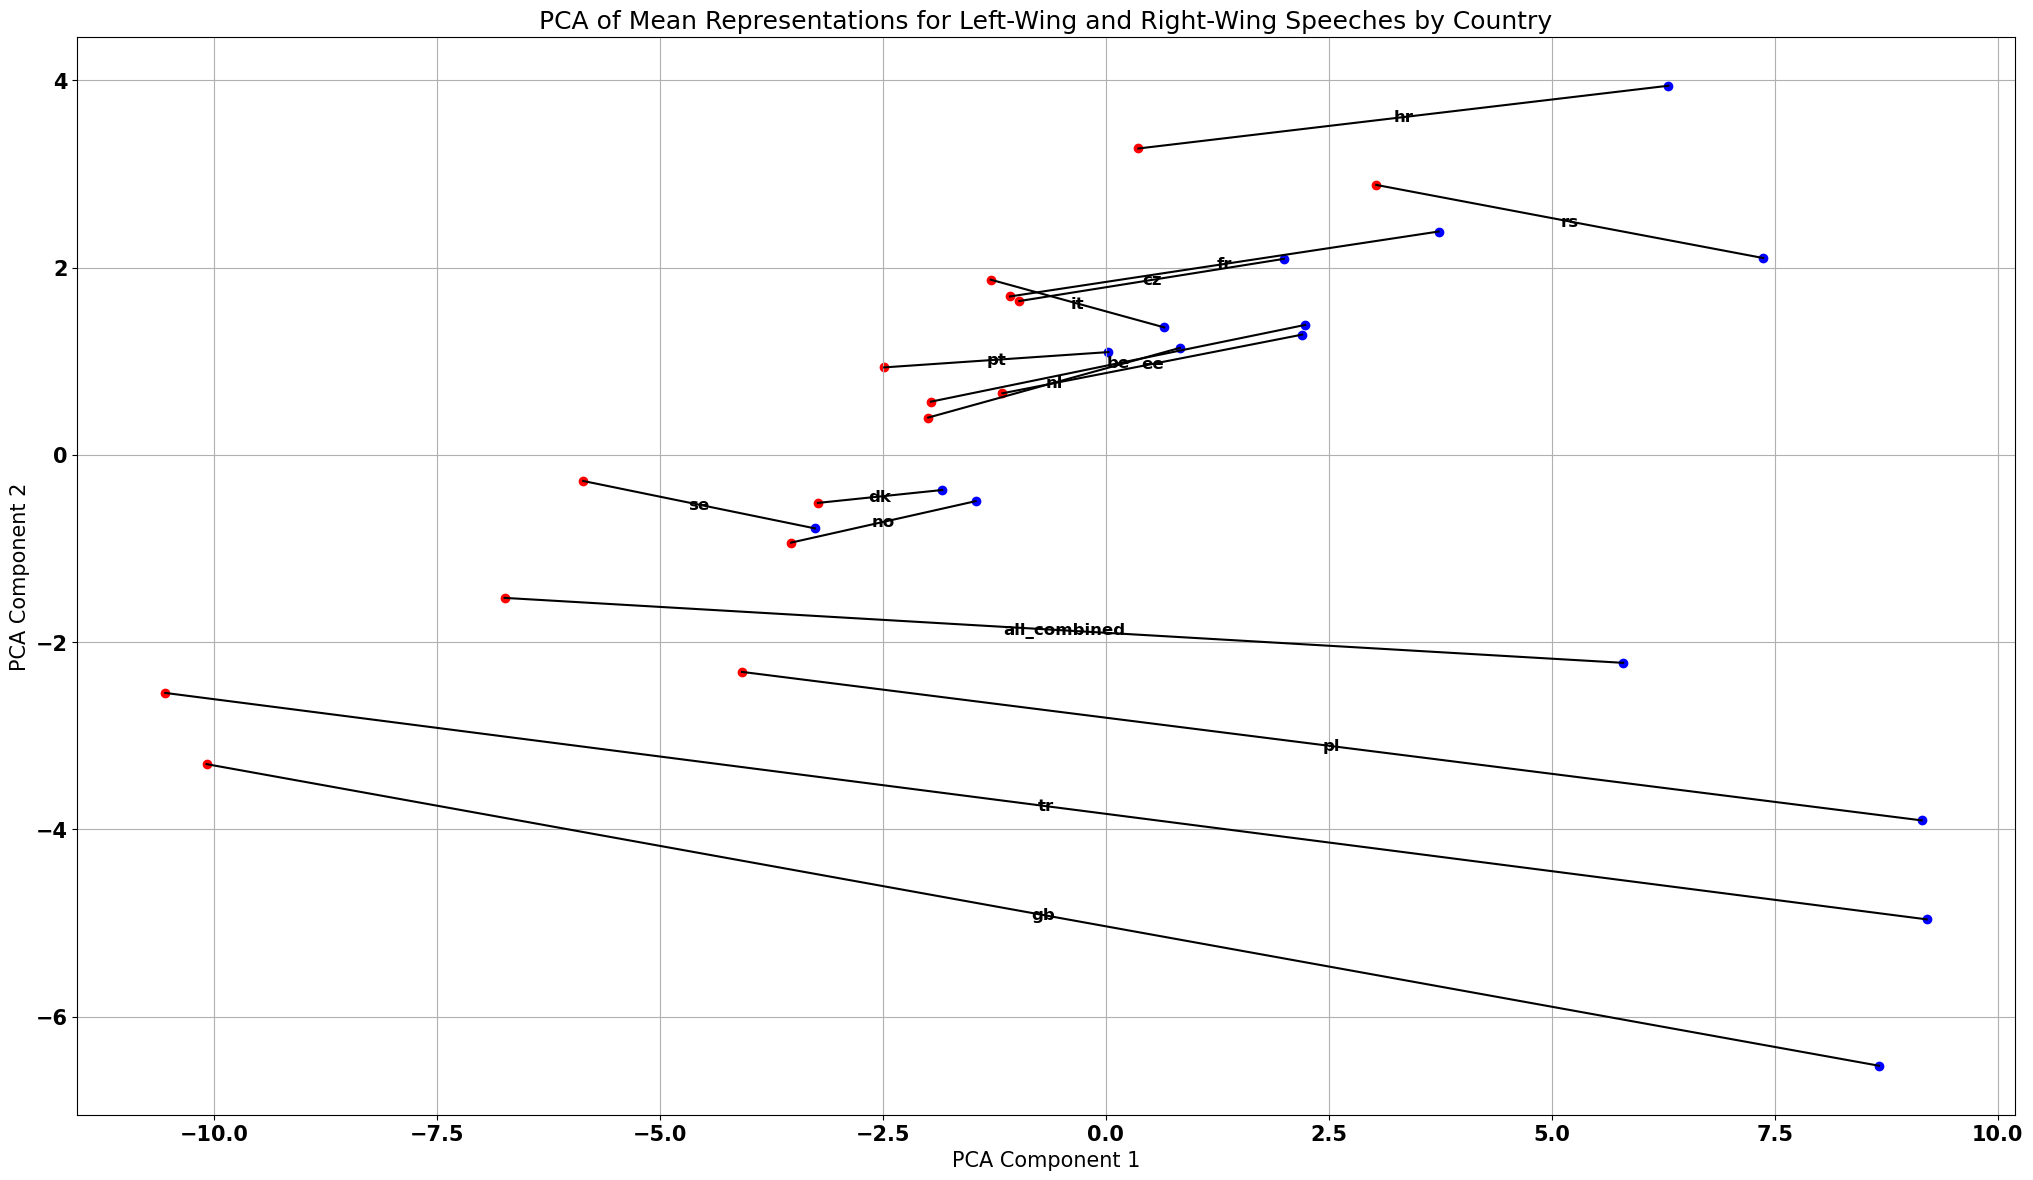

In [22]:
# Calculate mean representations for each country and label
mean_representations_ctr = calculate_mean_by_country(tr_countries, tr_labels, tr_representations, threshold=500)
print("Calculated all representations!")

# Prepare data for PCA
mean_reps_ctr = np.array(list(mean_representations_ctr.values()))
countries_labels_ctr = list(mean_representations_ctr.keys())

# Perform PCA
pca_result_ctr = perform_PCA(mean_reps_ctr)

#Plot results
plot_country(pca_result_ctr, countries_labels_ctr)

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.


Calculated all representations!


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

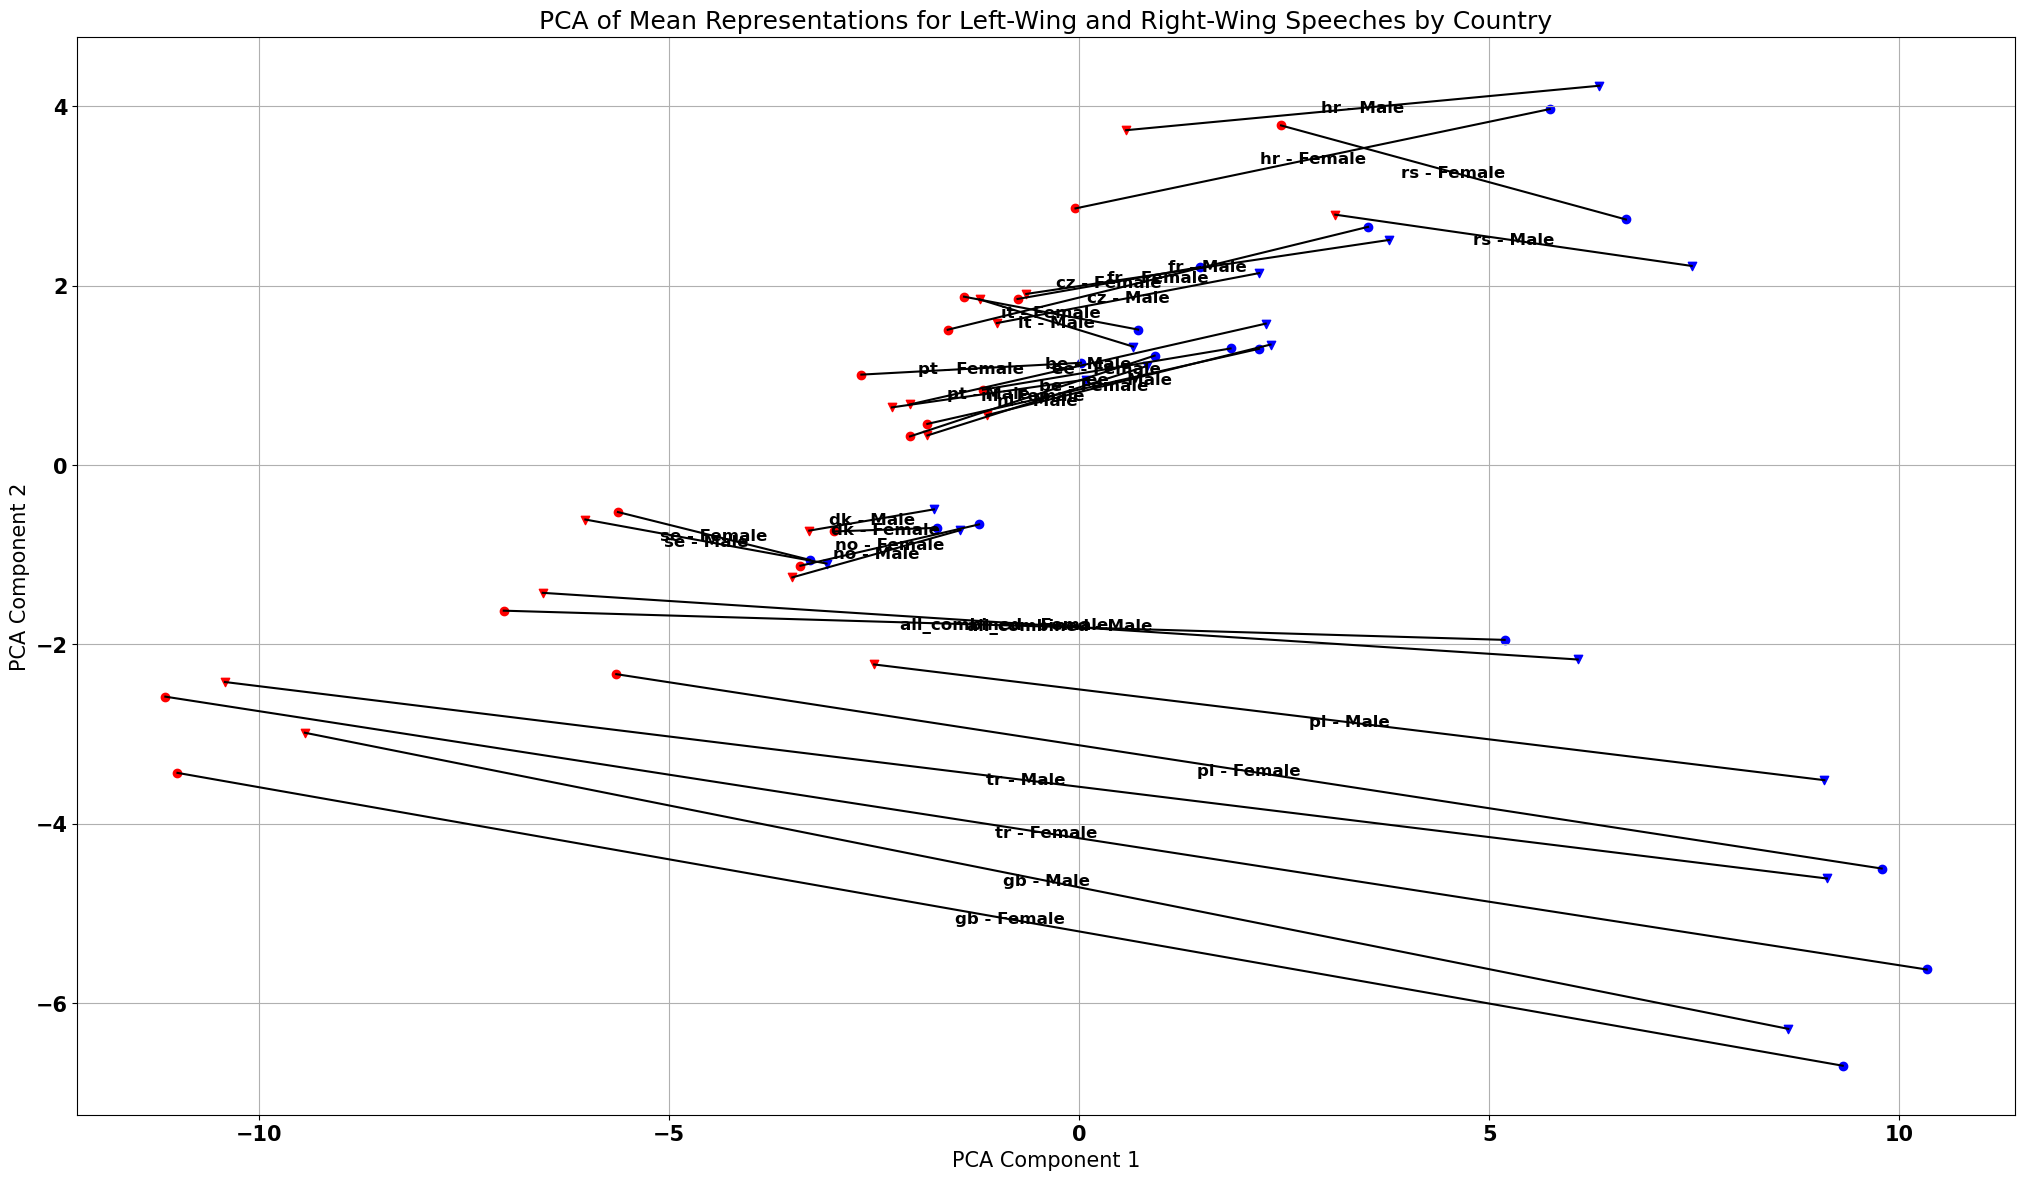

In [23]:
# Calculate mean representations for each country and label
mean_representations_cstr = calculate_mean_by_country_sex(tr_countries, tr_labels, tr_representations, tr_sexes, threshold=500)
print("Calculated all representations!")

# Prepare data for PCA
mean_reps_cstr = np.array(list(mean_representations_cstr.values()))
countries_labels_cstr = list(mean_representations_cstr.keys())

# Perform PCA
pca_result_cstr = perform_PCA(mean_reps_cstr)

#Plot results
plot_country_sex(pca_result_cstr, countries_labels_cstr)

In [24]:
# Get BERT representations for the validation data
ts_representations, ts_labels, ts_countries, ts_sexes, ts_logits = extract_representations(filtered_c_dict['test'])

Processed test_dataset_all.pt
Processed test_dataset_orientation-at.pt
Processed test_dataset_orientation-ba.pt
Processed test_dataset_orientation-be.pt
Processed test_dataset_orientation-cz.pt
Processed test_dataset_orientation-dk.pt
Processed test_dataset_orientation-ee.pt
Processed test_dataset_orientation-es-ct.pt
Processed test_dataset_orientation-es-ga.pt
Processed test_dataset_orientation-es.pt
Processed test_dataset_orientation-fi.pt
Processed test_dataset_orientation-fr.pt
Processed test_dataset_orientation-gb.pt
Processed test_dataset_orientation-hr.pt
Processed test_dataset_orientation-hu.pt
Processed test_dataset_orientation-is.pt
Processed test_dataset_orientation-it.pt
Processed test_dataset_orientation-lv.pt
Processed test_dataset_orientation-nl.pt
Processed test_dataset_orientation-no.pt
Processed test_dataset_orientation-pl.pt
Processed test_dataset_orientation-pt.pt
Processed test_dataset_orientation-rs.pt
Processed test_dataset_orientation-se.pt
Processed test_datase

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.


Calculated all representations!


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

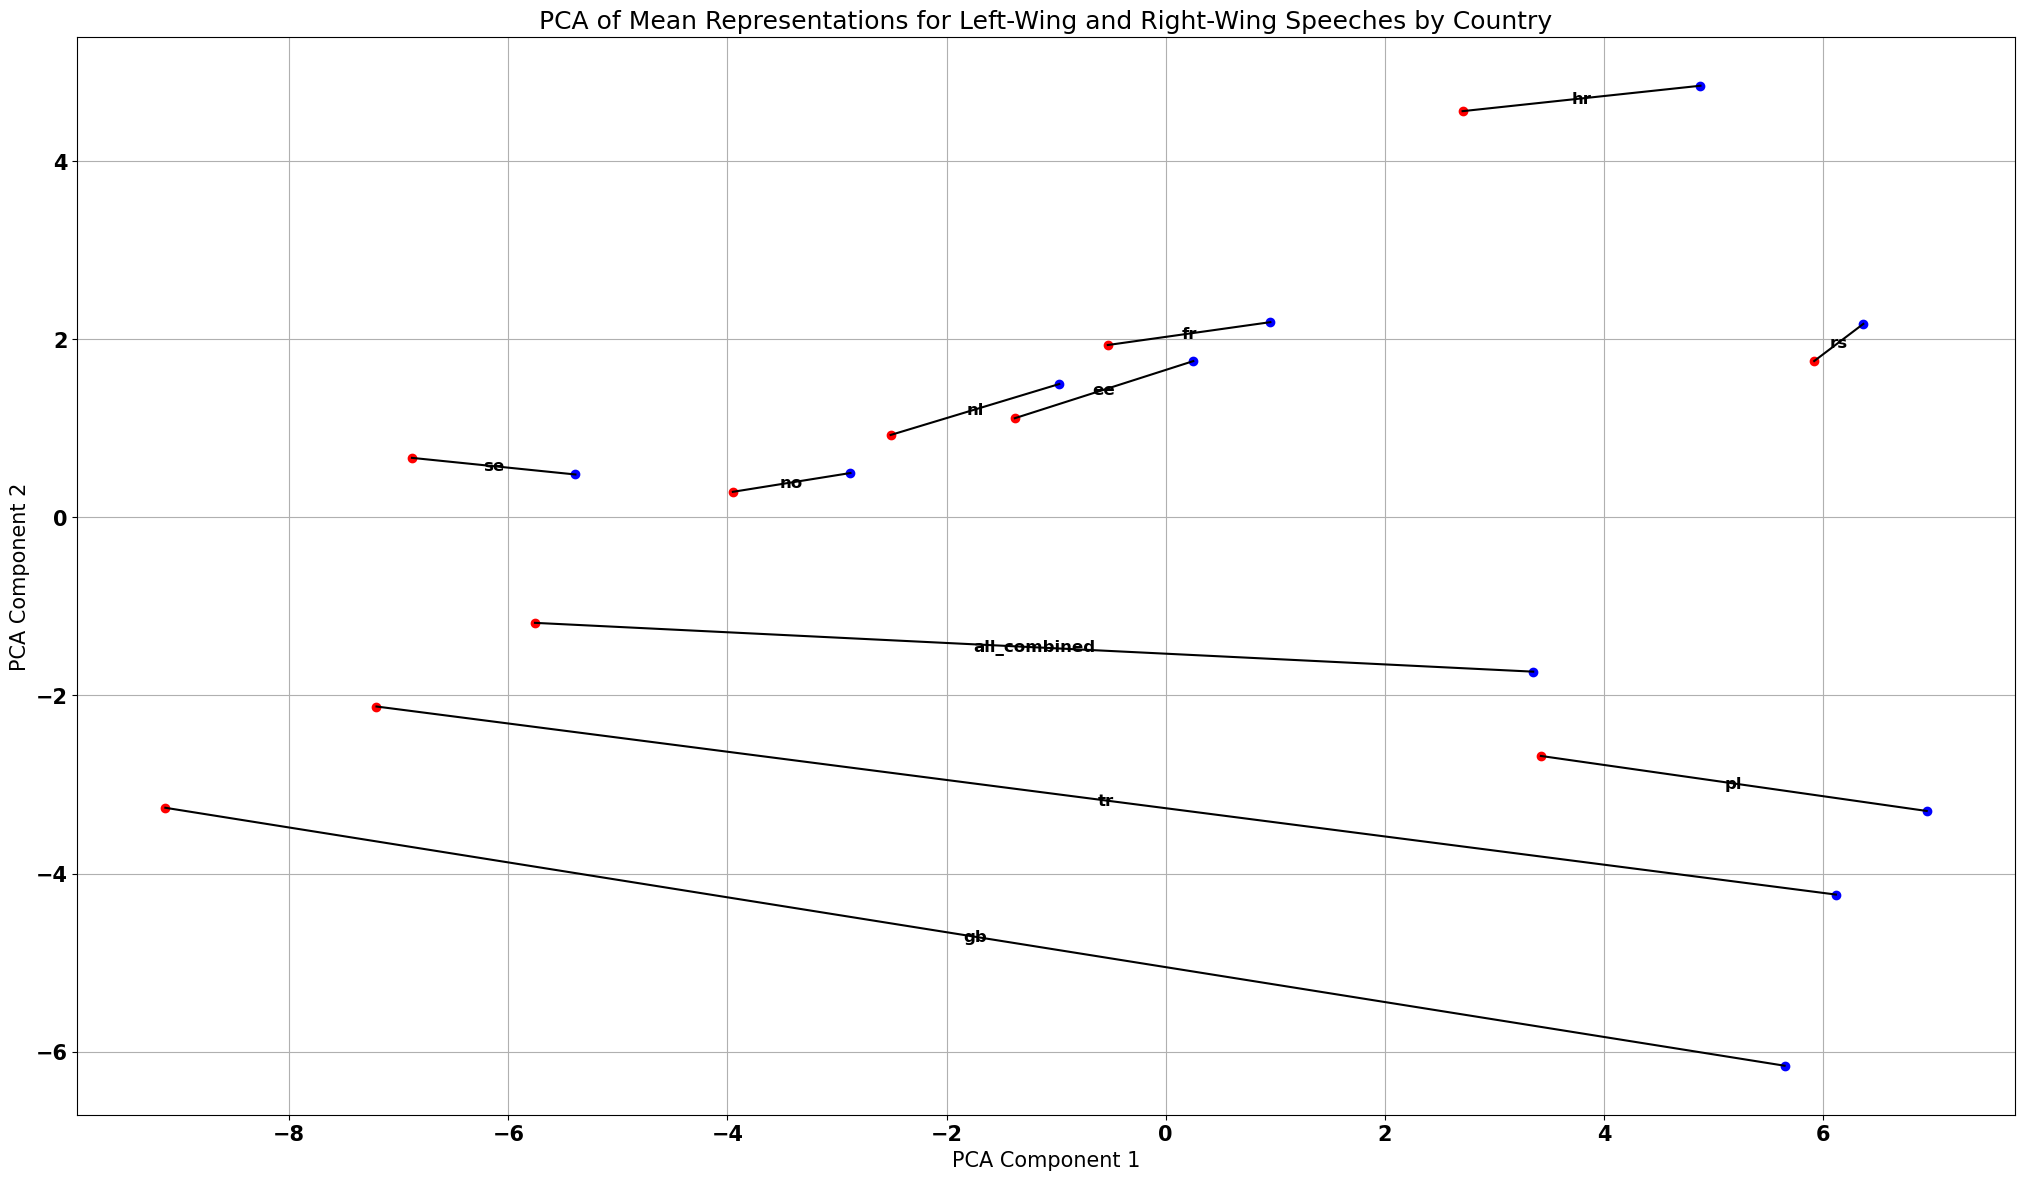

In [25]:
# Calculate mean representations for each country and label
mean_representations_cts = calculate_mean_by_country(ts_countries, ts_labels, ts_representations, threshold=100)
print("Calculated all representations!")

# Prepare data for PCA
mean_reps_cts = np.array(list(mean_representations_cts.values()))
countries_labels_cts = list(mean_representations_cts.keys())

# Perform PCA
pca_result_cts = perform_PCA(mean_reps_cts)

#Plot results
plot_country(pca_result_cts, countries_labels_cts)

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

Calculated all representations!


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

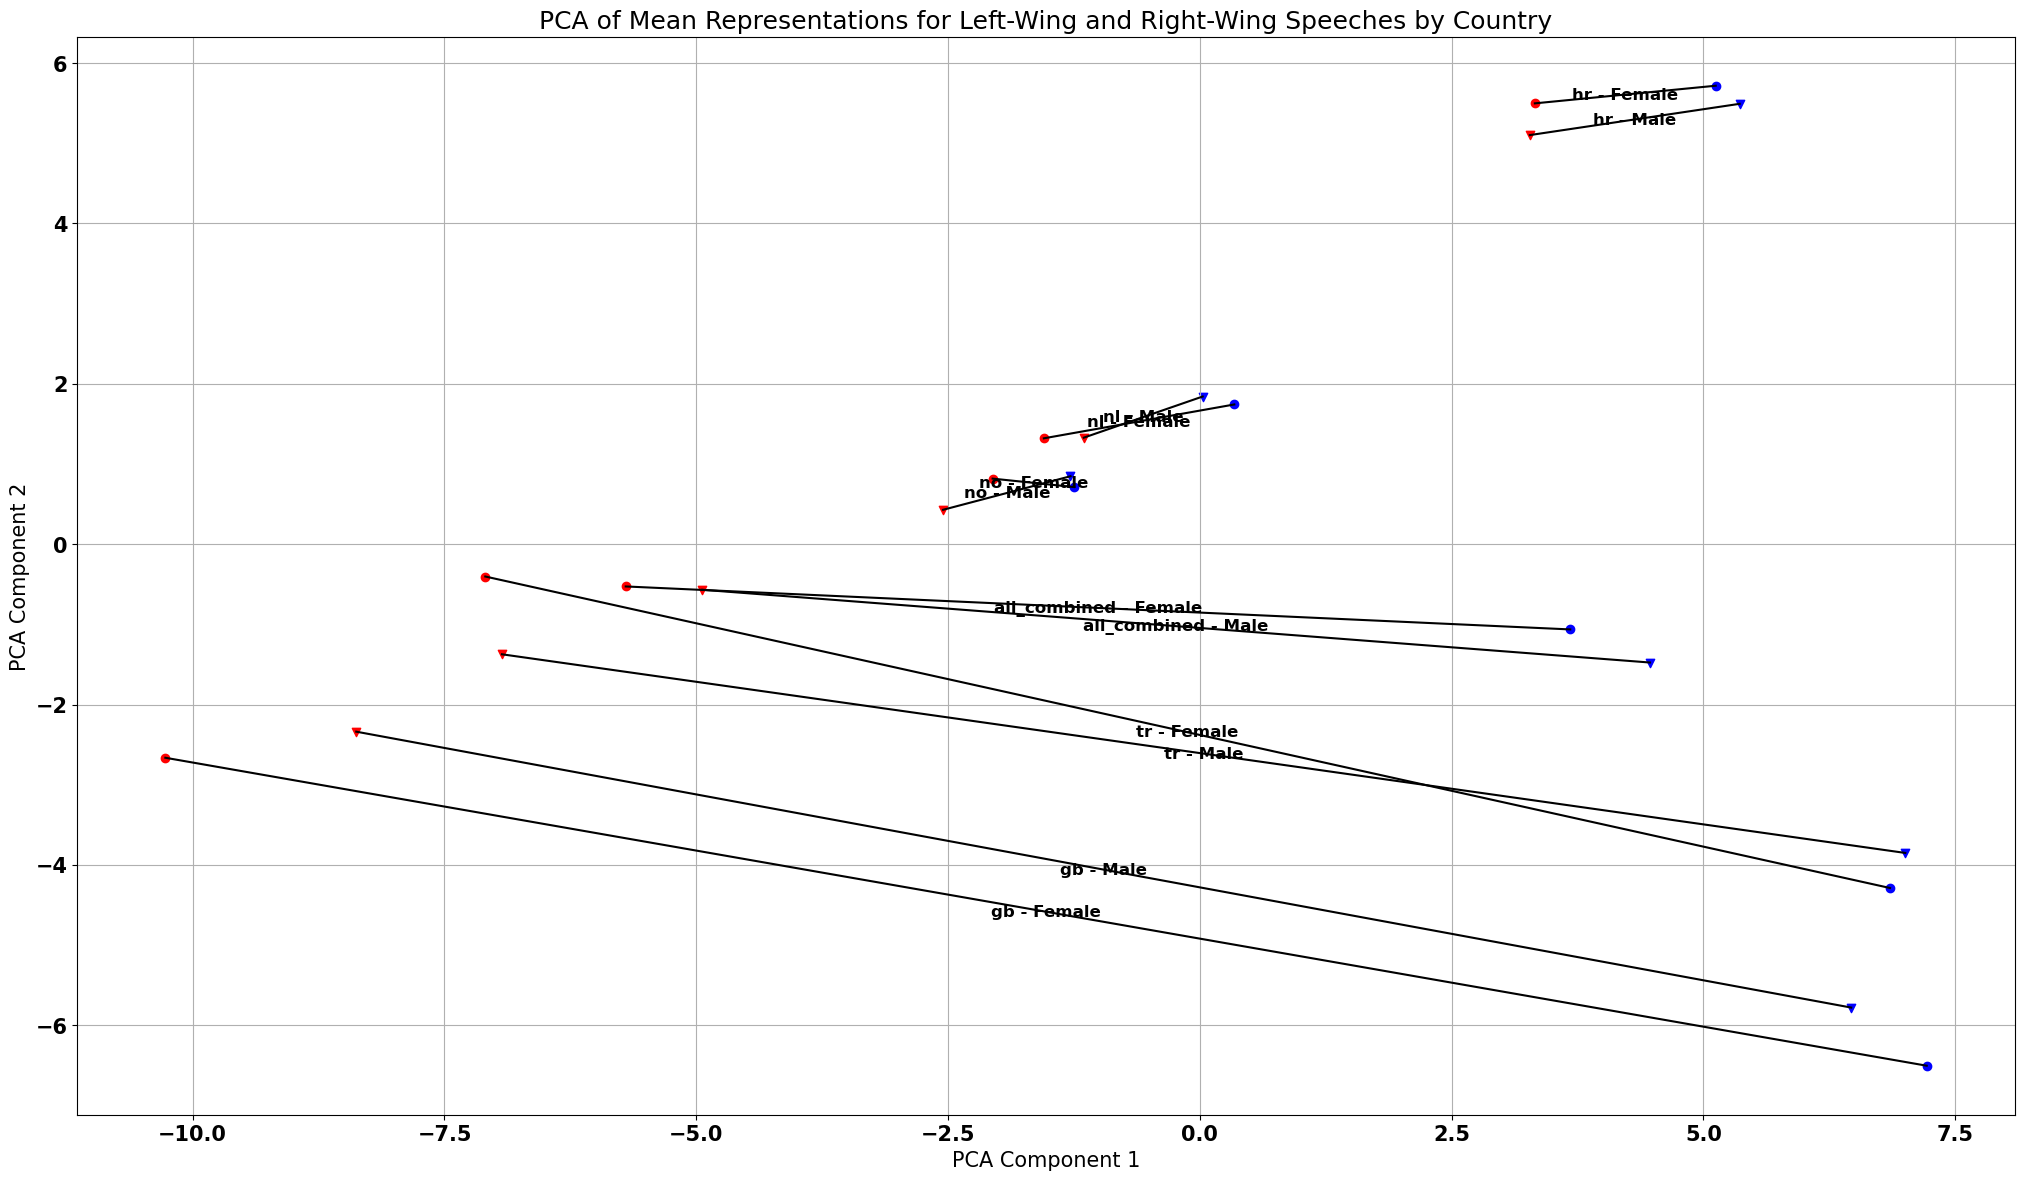

In [26]:
# Calculate mean representations for each country and label
mean_representations_csts = calculate_mean_by_country_sex(ts_countries, ts_labels, ts_representations, ts_sexes, threshold=200)
print("Calculated all representations!")

# Prepare data for PCA
mean_reps_csts = np.array(list(mean_representations_csts.values()))
countries_labels_csts = list(mean_representations_csts.keys())

# Perform PCA
pca_result_csts = perform_PCA(mean_reps_csts)

#Plot results
plot_country_sex(pca_result_csts, countries_labels_csts)

Text(0.5, 1.0, 'Weighted F1 by Country')

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

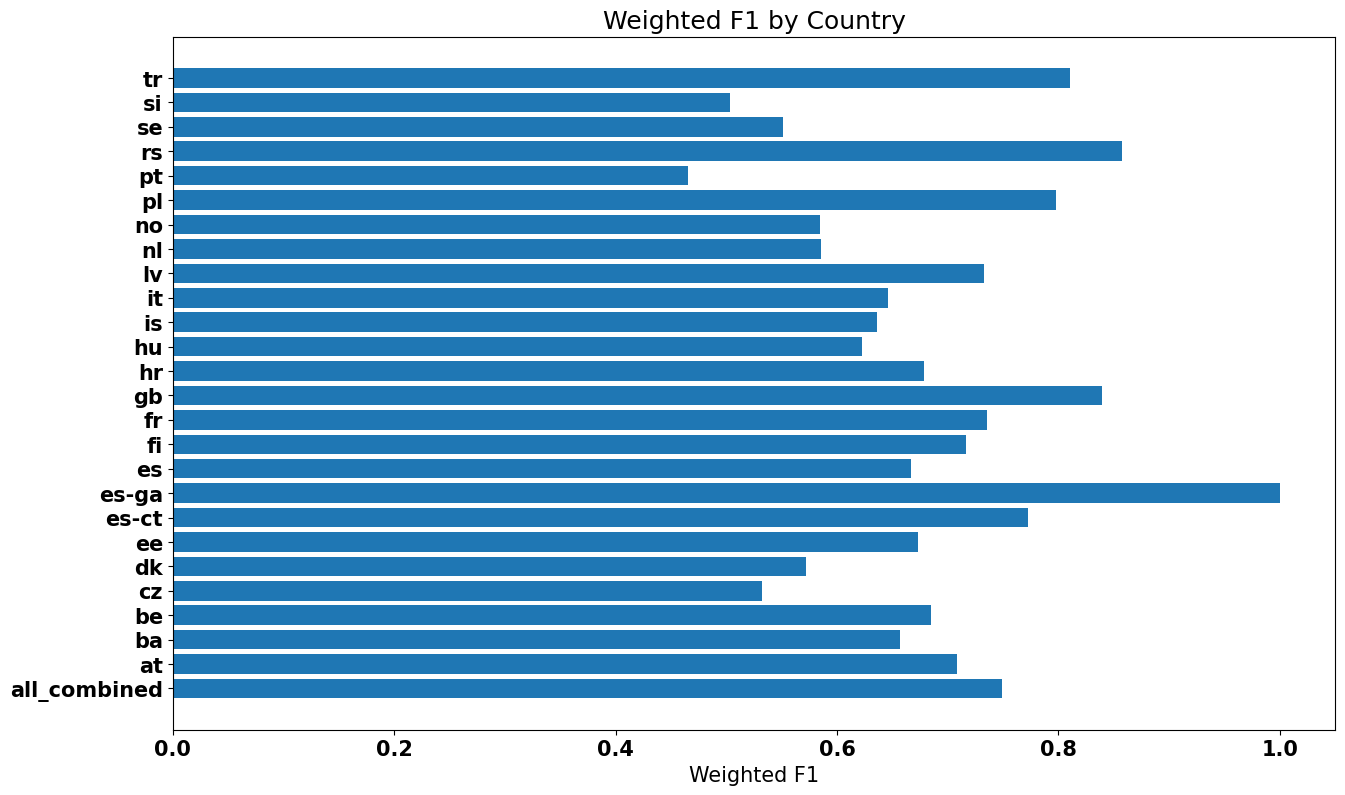

In [27]:
plt.figure(figsize=(15, 9))
c_names = list(map(extract_country_code, list(performance.keys())))
plt.barh(c_names, list(performance.values()))
plt.xlabel('Weighted F1')
plt.title('Weighted F1 by Country')

In [28]:
def calculate_mean_probabilities(countries, predictions, labels, threshold = 1):
    country_means = {}
    for country in np.unique(countries):
        #print(f"Processing country: {country}")
        country_indices = countries == country
        country_labels = labels[country_indices]
        if country_labels.shape[0] < threshold:
            continue
        country_predictions = predictions[country_indices]
        country_predictions = np.exp(country_predictions)
        country_predictions = country_predictions / np.sum(country_predictions, axis=1)[:, np.newaxis]
        if country_labels.size > 0:  
            right_mean = np.mean(country_predictions[country_labels == 1][:, 1])
            left_mean = np.mean(country_predictions[country_labels == 0][:, 0])
            country_means[country] = (right_mean, left_mean)
            #print(f"Country: {country}, Right Mean: {right_mean}, Left Mean: {left_mean}")
        else:
            print(f"No data for country: {country}")
    return country_means

In [29]:
country_means = calculate_mean_probabilities(ts_countries, ts_logits, ts_labels, threshold=100)
countries = list(country_means.keys())
right_means = [country_means[c][0] for c in countries]
left_means = [country_means[c][1] for c in countries]

Text(0.5, 1.0, 'Right-Wing Mean Probabilities by Country')

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

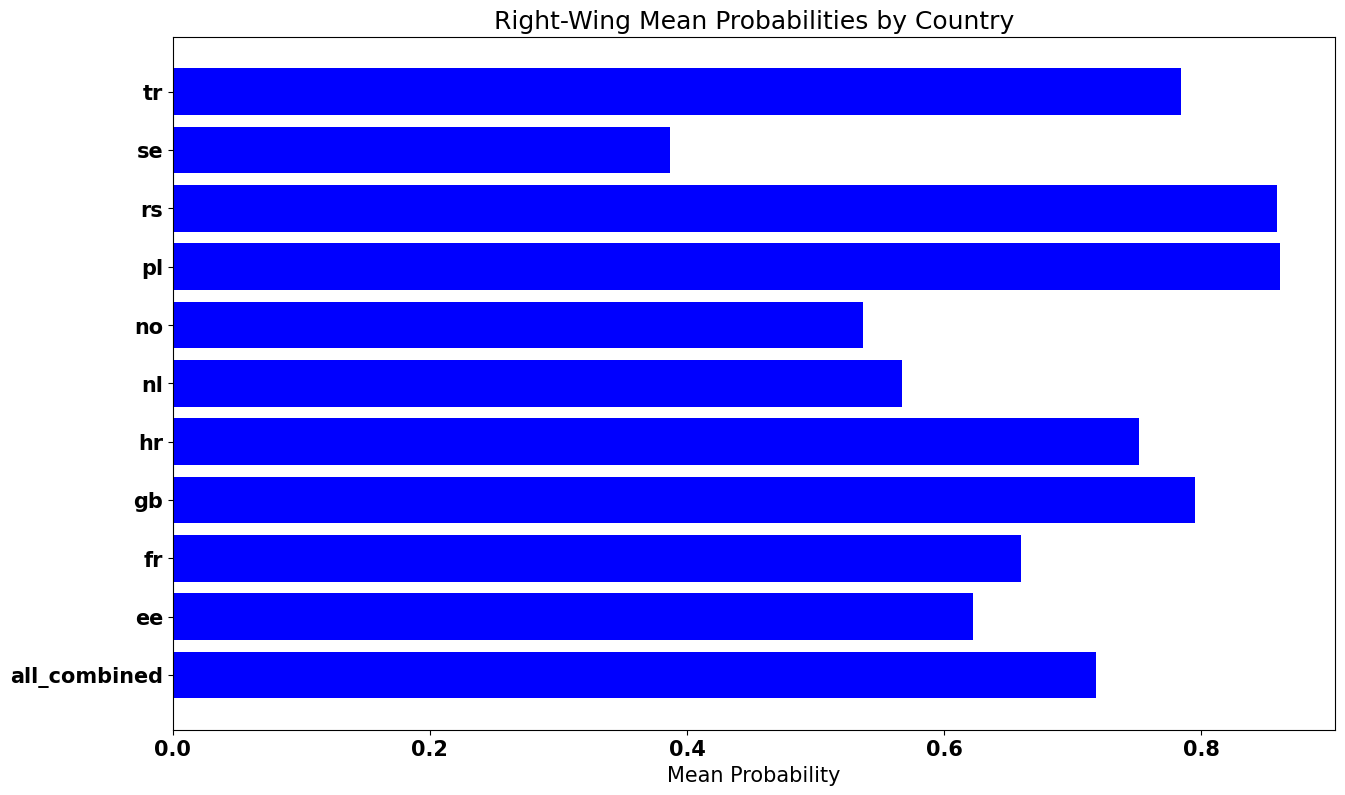

In [30]:
plt.figure(figsize=(15, 9))
plt.barh(countries, right_means, color='blue')
plt.xlabel('Mean Probability')
plt.title('Right-Wing Mean Probabilities by Country')

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

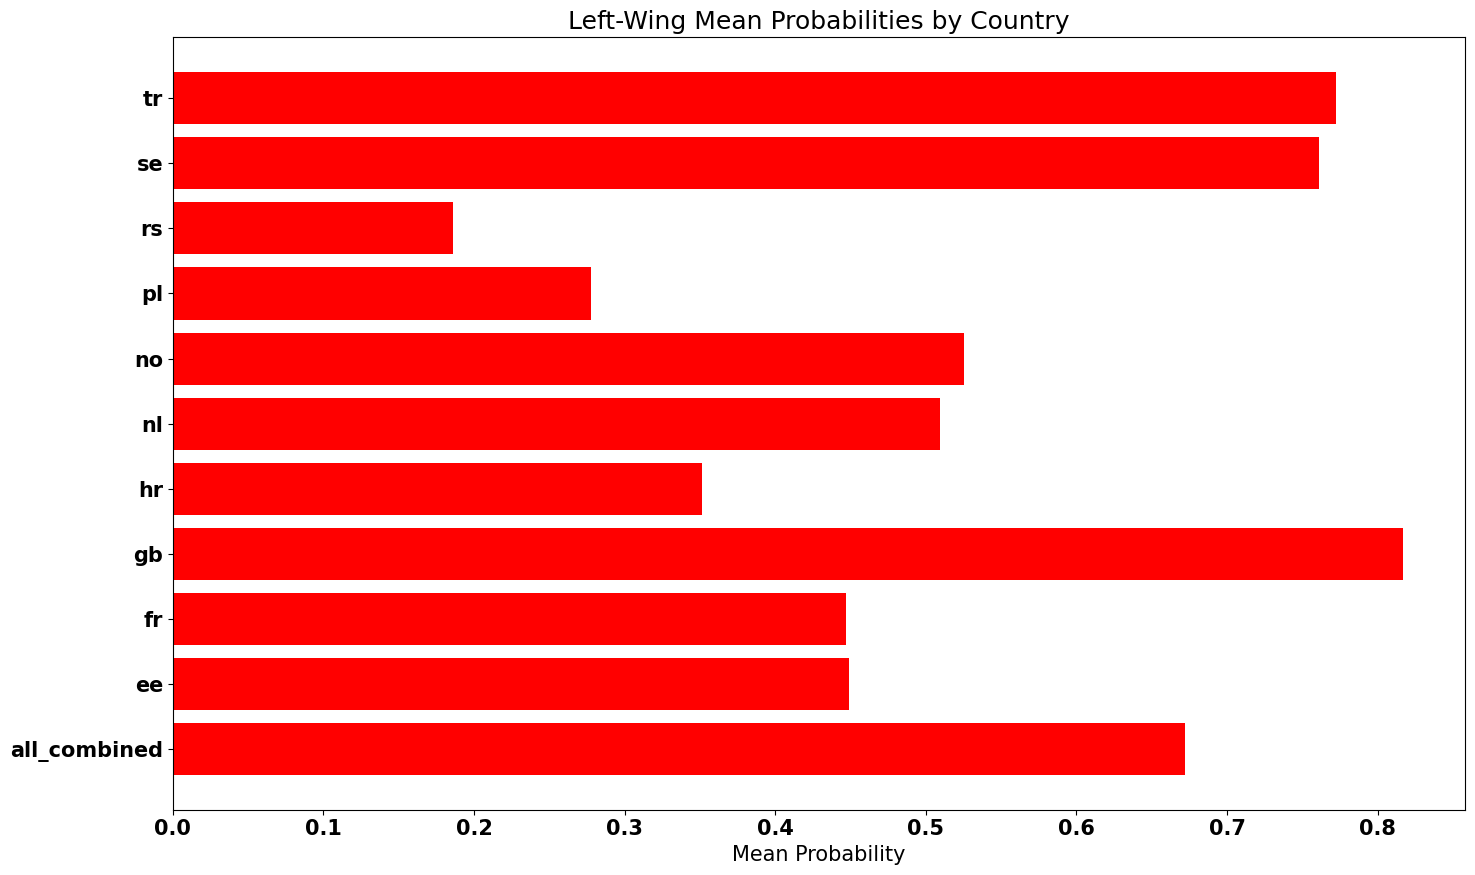

In [31]:
plt.figure(figsize=(15, 9))
plt.barh(countries, left_means, color='red')
plt.xlabel('Mean Probability')
plt.title('Left-Wing Mean Probabilities by Country')

plt.tight_layout()
plt.show()